# Language Changes

Group 5

- Alexander Bek, 
- Evelyn Birnzain,
- Eszter Iklódi,
- Anton Wohlgemuth

#### General questions of the task

- How does the use of various communication languages in countries change over time? 
- Which languages grow and which disappear, and what are their characteristics? 
- Are there other factors that correlate with the appearance or disappearance of languages?

#### Challenges of the task

- How to define extinction for languages? No native users? No one understands at all? 
- The ultimate historical data on language use of Ethnologue is way too expensive for a university project.
- There's a bias that there's more data for frequently used languages.

#### Restrictions

- Use only European data.
- Use data earliest from 1980s.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import explained_variance_score

## Explore: Look into endangered languages data

(Eszter Iklódi)

#### Endangered languages

- https://www.kaggle.com/the-guardian/extinct-languages/version/1 (updated in 2016)
- original data: http://www.unesco.org/languages-atlas/index.php?hl=en&page=atlasmap (published in 2010)

#### Countries of the world

- https://www.ethnologue.com/sites/default/files/CountryCodes.tab

Detailed processing: https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/unesco_endangered_lang_europe.ipynb

#### First let's plot the distribution!

In [2]:
# https://www.kaggle.com/the-guardian/extinct-languages/version/1
df_end = pd.read_csv("data/endangerment/extinct_languages.csv")
df_end.head()

,ID,Name in English,Name in French,Name in Spanish,Countries,Country codes alpha 3,ISO639-3 codes,Degree of endangerment,Alternate names,Name in the language,Number of speakers,Sources,Latitude,Longitude,Description of the location
0,1022,South Italian,italien du sud,napolitano-calabrés,Italy,ITA,nap,Vulnerable,Neapolitan; Neapolitan-Calabrese; неаполитанск...,NaN,7500000.0,NaN,40.9798,15.2490,"Campania, Lucania (Basilicata), Abruzzi (Abruz..."
1,1023,Sicilian,sicilien,siciliano,Italy,ITA,scn,Vulnerable,NaN,NaN,5000000.0,NaN,37.4399,14.5019,"Sicily (Sicilia), southern and central Calabri..."
2,383,Low Saxon,bas-saxon,bajo sajón,"Germany, Denmark, Netherlands, Poland, Russian...","DEU, DNK, NLD, POL, RUS","act, drt, frs, gos, nds, sdz, stl, twd, vel, wep",Vulnerable,"Low German, Niedersächsisch, Nedersaksisch, Ni...",Neddersassisch,4800000.0,NaN,53.4029,10.3601,"northern Germany, the north-eastern part of th..."
3,335,Belarusian,biélorusse,bielorruso,"Belarus, Latvia, Lithuania, Poland, Russian Fe...","BRB, LVA, LTU, POL, RUS, UKR",bel,Vulnerable,NaN,NaN,4000000.0,Hienadź Cychun: Weißrussisch. — Lexikon der Sp...,53.9560,27.5756,Belarus except the Polesian-speaking south-wes...
4,382,Lombard,lombard,lombardo,"Italy, Switzerland","ITA, CHE",lmo,Definitely endangered,NaN,NaN,3500000.0,NaN,45.7215,9.3273,the region of Lombardy (except the southernmos...


<AxesSubplot:>

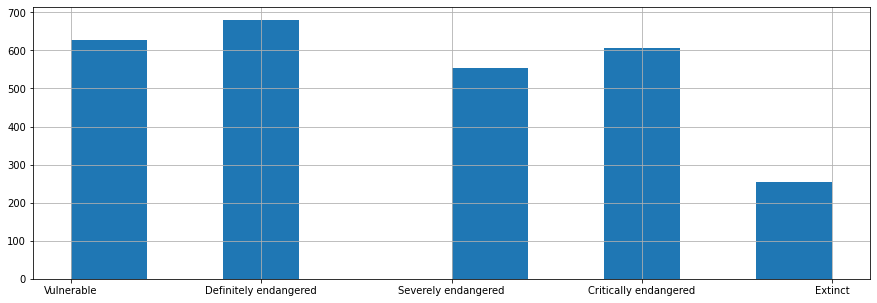

In [3]:
# Map textual degree of endangerment to numeric value
ENDANGERMENT_MAP = {
    "Vulnerable": 1,
    "Definitely endangered": 2,
    "Severely endangered": 3,
    "Critically endangered": 4,
    "Extinct": 5,
}
df_end["Endangerment code"] = df_end["Degree of endangerment"].apply(lambda x: ENDANGERMENT_MAP[x])
df_end["Degree of endangerment"].hist(figsize=(15,5))

#### Show languages on map

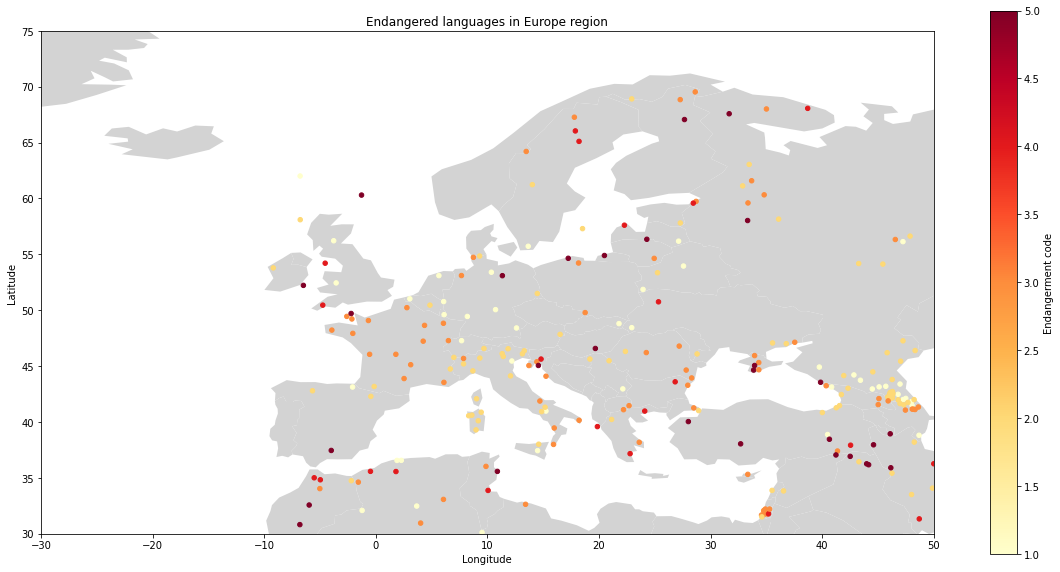

In [4]:
countries_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(figsize=(20, 10))

# Plot Europe
countries_map.plot(color='lightgrey', ax=ax)
plt.xlim([-30, 50])
plt.ylim([30, 75])

df_end.plot(
    x="Longitude", 
    y="Latitude", 
    kind="scatter", 
    title="Endangered languages in Europe region", 
    c="Endangerment code", 
    colormap="YlOrRd",
    ax=ax,
)

plt.show()

#### Filter European languages

In [5]:
# https://www.ethnologue.com/sites/default/files/CountryCodes.tab
countries = pd.read_csv("data/general/country_codes.tsv", sep="\t")
europe = countries[countries["Area"] == "Europe"]
europe_countries = set(europe["Name"].to_list())

# Clean data
df_end = df_end[df_end["Countries"].notna()]

# Filter
df_end["In Europe"] = df_end["Countries"].apply(lambda x: len(europe_countries.intersection(set(x.split(",")))) > 0)
df_europe = df_end.loc[df_end["In Europe"] == True]

df_europe.head()

/tmp/ipykernel_213176/2900314512.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end["In Europe"] = df_end["Countries"].apply(lambda x: len(europe_countries.intersection(set(x.split(",")))) > 0)


,ID,Name in English,Name in French,Name in Spanish,Countries,Country codes alpha 3,ISO639-3 codes,Degree of endangerment,Alternate names,Name in the language,Number of speakers,Sources,Latitude,Longitude,Description of the location,Endangerment code,In Europe
0,1022,South Italian,italien du sud,napolitano-calabrés,Italy,ITA,nap,Vulnerable,Neapolitan; Neapolitan-Calabrese; неаполитанск...,NaN,7500000.0,NaN,40.9798,15.2490,"Campania, Lucania (Basilicata), Abruzzi (Abruz...",1,True
1,1023,Sicilian,sicilien,siciliano,Italy,ITA,scn,Vulnerable,NaN,NaN,5000000.0,NaN,37.4399,14.5019,"Sicily (Sicilia), southern and central Calabri...",1,True
2,383,Low Saxon,bas-saxon,bajo sajón,"Germany, Denmark, Netherlands, Poland, Russian...","DEU, DNK, NLD, POL, RUS","act, drt, frs, gos, nds, sdz, stl, twd, vel, wep",Vulnerable,"Low German, Niedersächsisch, Nedersaksisch, Ni...",Neddersassisch,4800000.0,NaN,53.4029,10.3601,"northern Germany, the north-eastern part of th...",1,True
3,335,Belarusian,biélorusse,bielorruso,"Belarus, Latvia, Lithuania, Poland, Russian Fe...","BRB, LVA, LTU, POL, RUS, UKR",bel,Vulnerable,NaN,NaN,4000000.0,Hienadź Cychun: Weißrussisch. — Lexikon der Sp...,53.9560,27.5756,Belarus except the Polesian-speaking south-wes...,1,True
4,382,Lombard,lombard,lombardo,"Italy, Switzerland","ITA, CHE",lmo,Definitely endangered,NaN,NaN,3500000.0,NaN,45.7215,9.3273,the region of Lombardy (except the southernmos...,2,True


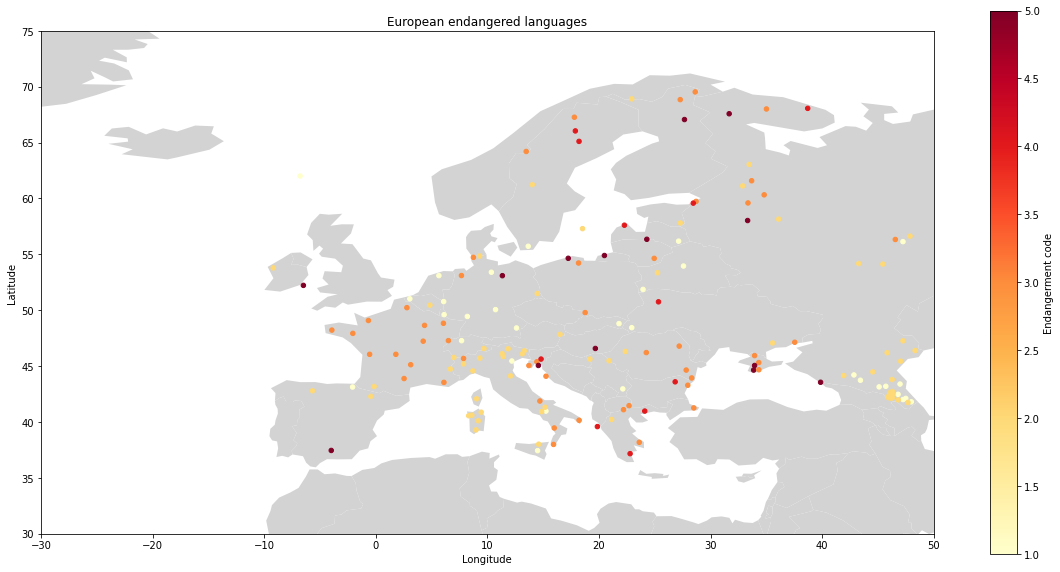

In [6]:
# Plot only European endangered languages
fig, ax = plt.subplots(figsize=(20, 10))

countries_map.plot(color='lightgrey', ax=ax)
plt.xlim([-30, 50])
plt.ylim([30, 75])

df_europe.plot(
    x="Longitude", 
    y="Latitude", 
    kind="scatter", 
    title="European endangered languages", 
    c="Endangerment code", 
    colormap="YlOrRd",
    ax=ax,
)

plt.show()

## Question 1: Which digital resources are the most important for the survival of a language?

(Eszter Iklódi)

### Data

#### Digital Language Death

Paper (2012): https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077056  
Data: http://hlt.sztaki.hu/resources/  
Data description: http://hlt.sztaki.hu/resources/dld-header.pdf  
Online version: https://hlt.bme.hu/en/dld/  

#### Crúbadán project

DLD data uses the Crúbadán crawls. The aim of this project is the creation of text corpora for a large number of under-resourced languages by crawling the web. It supports more than 2000 languages.

Paper (2007): https://cs.slu.edu/~scannell/pub/wac3.pdf  
Project website: http://crubadan.org/

Detailed processing: https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/dld_european_lang.ipynb

#### Prepare data

In [7]:
# http://hlt.sztaki.hu/resources/dld-joined.tsv
dld = pd.read_csv("data/digital/dld_joined.tsv", sep="\t", skiprows=2, low_memory=False)

LANG_ID = "LangID"

######################
# Columns of interest
######################

# Ids & Names
PRINT_NAME = "Print_Name" # standardized English language name
LANG_LOC = "language (local)" # the local name of the language
SIL = "SIL code" # SIL code

# Endangerment status
ETHN = "Eth_Language Status" # the EGIDS status of the language according to the Ethnologue.
ELP = "end_class" # classification according to the Endangered Languages Project (the higher, the more endangered)

# Speakers
L1 = "L1" # number of people speaking the language natively (L1 speakers)
L2 = "L2" # number of people speaking the language as second language (L2 speakers)

# Wikipedia
WP_NAME = "wikiname" # the two-letter (sometimes longer) code used in Wikipedia
WP_ART = "articles" # number of articles in wikipedia (2012 May)
WP_SIZE_ADJ = "adjusted WP size" # character count of ‘real’ wikipedia pages
WP_SIZE_CH = "WP size in chars" # raw (unadjusted) character count of wikipedia
WP_INCUB = "WP_incubator_new" # whether Wikipedia had an incubator for the language in March 2013
WP_AVG_LEN = "avg good page length" # average length of ‘real’ wikipedia pages
WP_REAL_TOT = "real/ total ratio" #  proportion of ‘real’ and 'total' wikipedia pages

# Windows
MS_IN = "MS-if-pack" # Microsoft input-level support
MS_OS = "MS-pack" # OS-level support in Windows 7

# MAC
MAC_IN = "MAC-input" # input-level support by Apple
MAC_OS = "MAC-supp" # OS-level support in MacOS 10.6.8

# Spellchecker
HUN_STAT = "hunspell status" # whether a hunspell checker exists
HUN_COV = "hunspell coverage" # the percentage coverage Hunspell has on the wikipedia dump

# Crúbadán
CR1_ID = "cru1_ISO-639-3" # iso-code from first Crúbadán summary
CR2_ID = "cru2_ISO-639-3" # iso-code from second Crúbadán summary

CR1_CH = "cru1_Characters" # number of characters found by the first Crúbadán crawl
CR2_CH = "cru2_Characters" # number of characters found by the second Crúbadán crawl

CR1_WORDS = "cru1_Words" # number of words found by the first Crúbadán crawl
CR2_WORDS = "cru2_Words" # number of words found by the second Crúbadán crawl

CR1_DOCS = "cru1_Docs" # number of documents found by the first Crúbadán crawl
CR2_DOCS = "cru2_Docs" # number of documents found by the second Crúbadán crawl

CR1_UDHR = "cru1_UDHR" # translation of the Universal Declaration of Human rights exists according to the first Crúbadán summary
CR2_UDHR = "cru2_UDHR" # translation of the Universal Declaration of Human rights exists according to the second Crúbadán summary

CR1_FLOSS = "cru1_FLOSS SplChk" # whether a FLOSS spellchecker exists according to the first Crúbadán summary
CR2_FLOSS = "cru2_FLOSS SplChk" # whether a FLOSS spellchecker exists according to the second Crúbadán summary

CR1_BIB = "cru1_WT" # whether an online Bible exists at watchtower.org according to the first Crúbadán summary
CR2_BIB = "cru2_WT" # whether an online Bible exists at watchtower.org according to the second Crúbadán summary

# Other
TLD = "TLDs(%)" # whether a national level Top Level Domain (not .com, .org, .edu) appeared in the top three domains that the crawl found language data in
OLAC = "la_Primary texts_Online" # the number of OLAC primary texts online

In [8]:
# Filter columns of interest

dld_fil = dld[[
    # Ids & names
    PRINT_NAME,
    LANG_LOC,
    SIL,    
    
    # Endangerment status
    ETHN,
    ELP,
    
    # Speakers
    L1,
    L2,
    
    # Wikipedia
    WP_NAME,
    WP_ART,
    WP_SIZE_ADJ,
    WP_SIZE_CH,
    WP_INCUB,
    WP_AVG_LEN,
    WP_REAL_TOT,
    
    # Windows
    MS_IN,
    MS_OS,
    
    # MAC
    MAC_IN,
    MAC_OS,
    
    # Spellchecker
    HUN_STAT,
    HUN_COV,
    
    # Crúbadán
    CR1_ID,
    CR2_ID,
    CR1_CH,
    CR2_CH,
    CR1_WORDS,
    CR2_WORDS,
    CR1_DOCS,
    CR2_DOCS,
    CR1_UDHR,
    CR2_UDHR,
    CR1_FLOSS,
    CR2_FLOSS,
    CR1_BIB,
    CR2_BIB,
    
    # Other
    TLD,
    OLAC
]]

dld_fil.head()

,Print_Name,language (local),SIL code,Eth_Language Status,end_class,L1,L2,wikiname,articles,adjusted WP size,...,cru1_Docs,cru2_Docs,cru1_UDHR,cru2_UDHR,cru1_FLOSS SplChk,cru2_FLOSS SplChk,cru1_WT,cru2_WT,TLDs(%),la_Primary texts_Online
0,0,0,0,7.7,7,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Tawandê,0,0,8.0,8,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Thawa,0,0,10.0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Cuyamecalco Mixtec,0,0,6.5,0,1880,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Tacahua Mixtec,0,0,6.5,0,390,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Filter for Europe

In [9]:
# Output of https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/ethnologue_lang_europe.ipynb
eur_lang = pd.read_csv("data/general/european_languages.csv")

eur_dld = eur_lang.join(dld_fil.set_index(CR2_ID), on="LangID", how="inner")
eur_dld.head()

,LangID,CountryID,LangStatus,Name_lang,Name_country,Area,Print_Name,language (local),SIL code,Eth_Language Status,...,cru1_Docs,cru2_Docs,cru1_UDHR,cru2_UDHR,cru1_FLOSS SplChk,cru2_FLOSS SplChk,cru1_WT,cru2_WT,TLDs(%),la_Primary texts_Online
0,aae,IT,L,"Albanian, Arbëreshë",Italy,Europe,Arbëreshë Albanian,0,0,6.5,...,1,0,-,-,no,no,-,-,0,0
3,fur,IT,L,Friulian,Italy,Europe,Friulian,Furlan,fur,5.0,...,8926,0,frl,frl,yes,yes,-,-,37.20 o 20.59 it 15.89 c,0
6,ita,IT,L,Italian,Italy,Europe,Italian,Italiano,ita,1.0,...,1212,0,itn,itn,yes,yes,i,i,27.57 o 24.86 it 23.21 c,22
8,lij,IT,L,Ligurian,Italy,Europe,Ligurian,Líguru,lij,5.0,...,40,0,-,-,no,no,-,-,32.46 o 15.15 it 14.52 c,0
9,lld,IT,L,Ladin,Italy,Europe,Ladin,0,0,6.5,...,399,0,-,-,no,no,rh,rh,0,0


#### Clean data

In [10]:
eur_dld_clean = eur_dld.copy()

# L1 is interpreted as object -> convert to int
eur_dld_clean[L1] = eur_dld[L1].astype(int)

# MAC OS support is given textual -> convert it to 0/1 (no data is also 0)
def apply_mac(x):
    if x == "TRUE":
        return 1
    return 0

eur_dld_clean[MAC_OS] = eur_dld[MAC_OS].apply(lambda x: apply_mac(x))

# Microsoft OS support is given textual -> convert it to 0/1 (no data is also 0)
def apply_win(x):
    if x == "P" or x == "F":
        return 1
    return 0

eur_dld_clean[MS_OS] = eur_dld[MS_OS].apply(lambda x: apply_win(x))

# UDHR and Bible availability is given textual -> convert it to 0/1 (if there's any it's 1)
def true_id_not_empty(x):
    if x == "-":
        return 0
    return 1

eur_dld_clean[CR1_UDHR] = eur_dld[CR1_UDHR].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR2_UDHR] = eur_dld[CR2_UDHR].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR1_BIB] = eur_dld[CR1_BIB].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR2_BIB] = eur_dld[CR2_BIB].apply(lambda x: true_id_not_empty(x))

# FLOSS availability is given textual -> convert it to 0/1 (no data is also 0)
def apply_floss(x):
    if x == "yes":
        return 1
    return 0

eur_dld_clean[CR1_FLOSS] = eur_dld[CR1_FLOSS].apply(lambda x: apply_floss(x))
eur_dld_clean[CR2_FLOSS] = eur_dld[CR2_FLOSS].apply(lambda x: apply_floss(x))

# Fill NaN with 0
eur_dld_clean[MS_IN] = eur_dld[MS_IN].fillna(0)
eur_dld_clean[HUN_COV] = eur_dld[HUN_COV].fillna(0)

#### Investigate correlation

<AxesSubplot:title={'center':'Correlation between numeric variables'}>

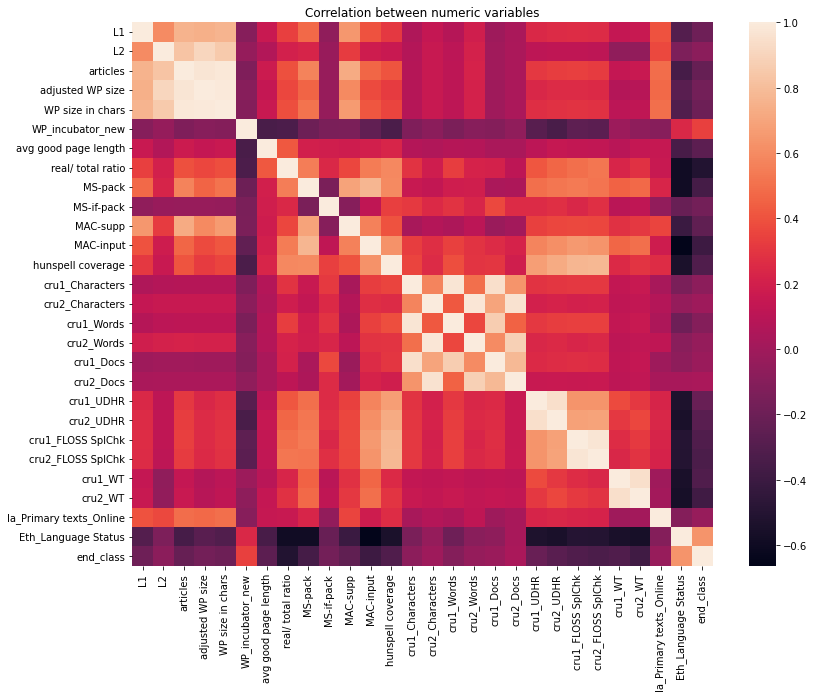

In [11]:
# Columns with numerical values
NUM_COLS = [
    L1,
    L2,
    WP_ART,
    WP_SIZE_ADJ, 
    WP_SIZE_CH, 
    WP_INCUB,
    WP_AVG_LEN,
    WP_REAL_TOT,
    MS_OS,
    MS_IN,
    MAC_OS,
    MAC_IN,
    HUN_COV,
    CR1_CH,
    CR2_CH,
    CR1_WORDS,
    CR2_WORDS,
    CR1_DOCS,
    CR2_DOCS,
    CR1_UDHR,
    CR2_UDHR,
    CR1_FLOSS,
    CR2_FLOSS,
    CR1_BIB,
    CR2_BIB,
    OLAC
]

STATUS_COLS = [
    ETHN,
    ELP,
]

# Correlation matrix of numerical values
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation between numeric variables")
corr = eur_dld_clean[NUM_COLS + STATUS_COLS].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<AxesSubplot:title={'center':'Enthologue status'}, xlabel='LangID'>

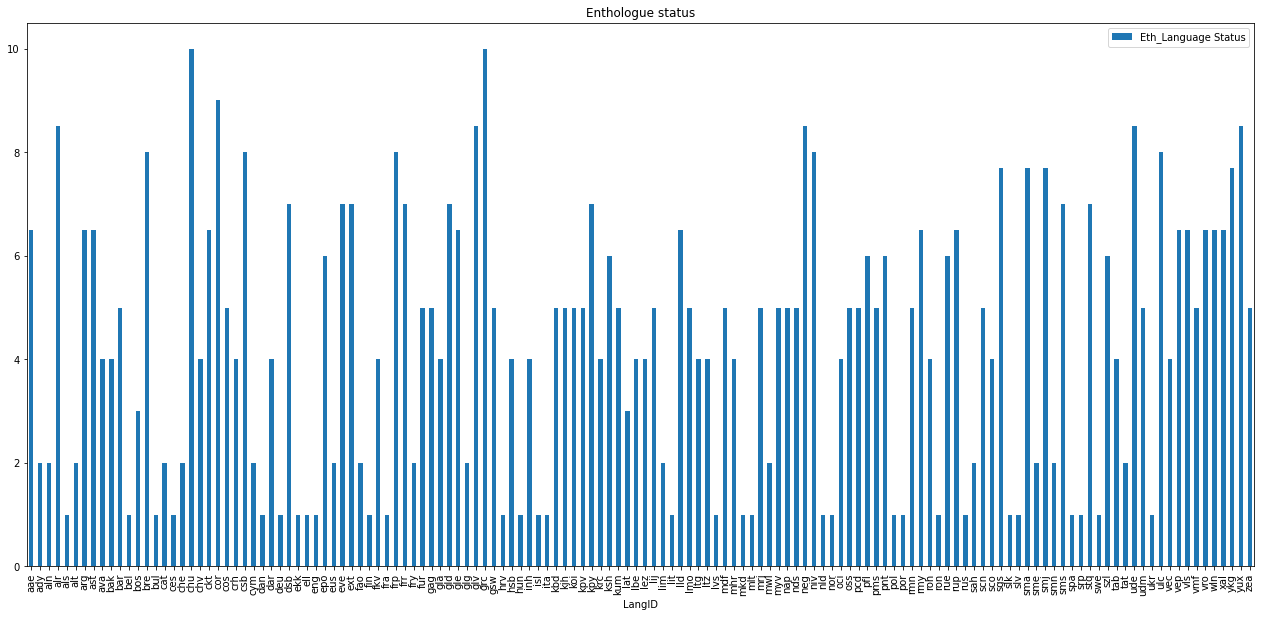

In [12]:
# Correlation with endangerment status of Ethnologue
eur_dld_clean.set_index(LANG_ID).sort_index().plot(y=ETHN, figsize=(22, 10), title="Enthologue status", kind="bar")

,Eth_Language Status
MAC-input,-0.663741
real/ total ratio,-0.590073
MS-pack,-0.587607
cru2_WT,-0.566121
cru1_WT,-0.548833
cru2_UDHR,-0.546941
hunspell coverage,-0.544136
cru1_UDHR,-0.529287
cru2_FLOSS SplChk,-0.502468
cru1_FLOSS SplChk,-0.495520


<AxesSubplot:title={'center':'Correlation with degree and availability of digital tools - Ethnologue'}>

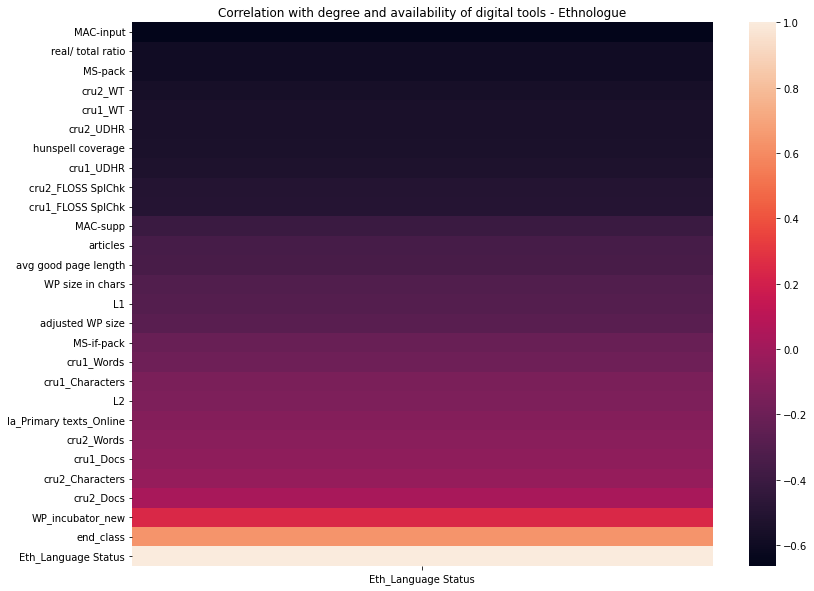

In [13]:
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation with degree and availability of digital tools - Ethnologue")

corr_ethn = corr[[ETHN]].sort_values(by=ETHN)
display(corr_ethn)
sns.heatmap(corr_ethn, 
        xticklabels=corr_ethn.columns,
        yticklabels=corr_ethn.index)

#### Fit model to find out most important factors

In [14]:
def create_dataset(data, label_to_predict, test_size=0.2, random_state=0):
    train, test = train_test_split(data, test_size=test_size, random_state=random_state)

    y = train[label_to_predict]
    y_true = test[label_to_predict]

    del train[label_to_predict]
    del test[label_to_predict]
    return train, test, y, y_true

def print_pred(y_true, y_pred, title):
    df = pd.DataFrame()
    df["y_true"] = y_true
    df["y_pred"] = y_pred
    df.sort_index().plot(y=["y_true", "y_pred"], figsize=(22, 10), title=title, kind="bar")
    
def print_coefs(cols, coefs):
    df = pd.DataFrame()
    df["Features"] = cols
    df["coefs"] = coefs
    df["coefs_abs"] = abs(coefs)
    display(df.sort_values(by="coefs_abs", ascending=False))
    
def print_score(y_true, y_pred, method):
    print(method(y_true, y_pred))

def fit(scaler, model, train, y, test, y_true, coefs=False, title=None):
    reg = make_pipeline(scaler, model)
    reg.fit(train, y)
    y_pred = reg.predict(test)
    print_score(y_true, y_pred, explained_variance_score)
    if coefs:
        print_coefs(train.columns, model.coef_)
    if title:
        print_pred(y_true, y_pred, title)
    return y_pred

In [15]:
# Create dataset
data = eur_dld_clean[NUM_COLS + [ETHN, LANG_ID]]
data.set_index("LangID", inplace=True)
train, test, y, y_true = create_dataset(data, ETHN, test_size=0.2, random_state=0)

-4.3965354501857705


,Features,coefs,coefs_abs
10,MAC-supp,-5.072919e+08,5.072919e+08
11,MAC-input,-2.110703e+08,2.110703e+08
8,MS-pack,-1.708168e+08,1.708168e+08
9,MS-if-pack,-3.701979e+07,3.701979e+07
21,cru1_FLOSS SplChk,1.334710e+07,1.334710e+07
12,hunspell coverage,1.227116e+07,1.227116e+07
7,real/ total ratio,8.289368e+06,8.289368e+06
22,cru2_FLOSS SplChk,-7.480005e+06,7.480005e+06
20,cru2_UDHR,2.953604e+05,2.953604e+05
23,cru1_WT,-1.933459e+05,1.933459e+05


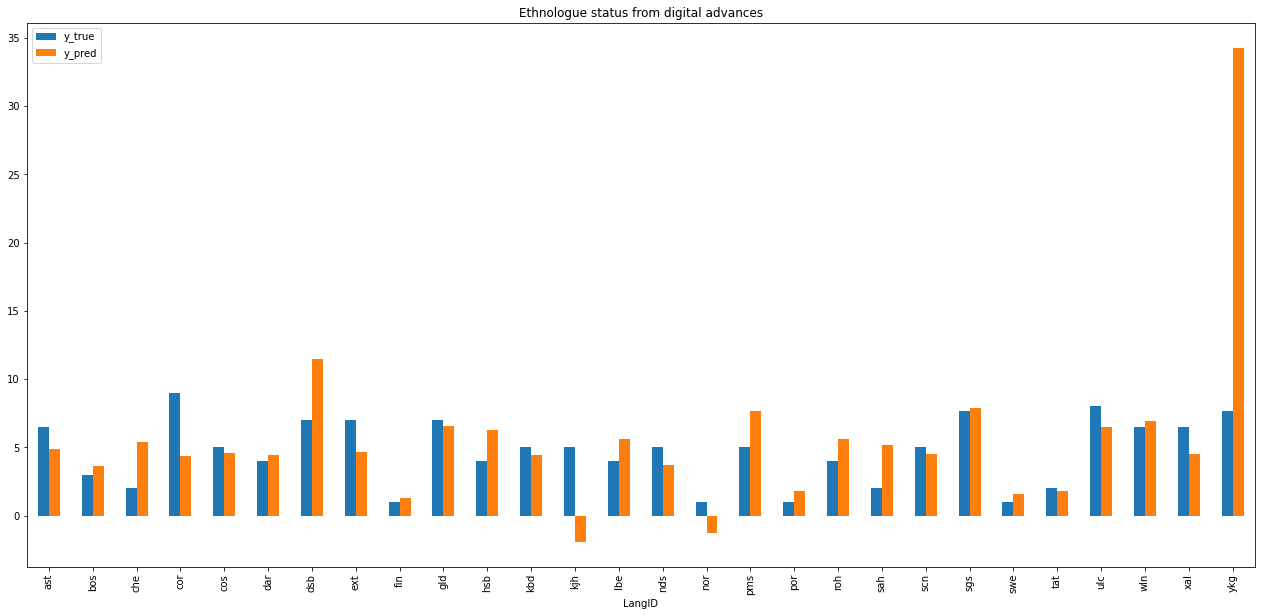

In [16]:
# Fit model
lr = LinearRegression()
y_pred_lr = fit(Normalizer(), lr, train, y, test, y_true, coefs=True, title="Ethnologue status from digital advances")

#### Conclusion

Most important digitalization factors for determining endangerment status:

- MAC and Windows OS level & input support
- The existence of a spellchecker and their word coverage.
- Ratio of real/total wikipedia pages.
- Availability of Bible and Universal Declaration of Human rights translations


Not so important features (for both metrics):

- Number of speakers.
- Character size of available resources.

# Q2: Can the endangerment status be predicted from internet usagedata?

Input
- language codes: https://www.ethnologue.com/sites/default/files/LanguageCodes.tab
- number-of-internet-users-by-country:

Output
- LangID: ISO 639-3 standard for language identifiers
- CountryID:
- Language: Language spoken
- Year: Year data was gathered
- Internet_users: number of active internet users
- Name_country: Name of the main country where used.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow import keras
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from os import listdir
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from os.path import isfile, join

/Users/anton/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anton/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anton/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anton/opt/anaconda3/lib/python3.8/site-packages/tensorflow/pyth

In [3]:
users_country = pd.read_csv("data/number-of-internet-users-by-country.csv")
#users_country = users_country.drop(users_country.columns[1], axis=1)
users_country.columns = ["Country",'CountryID', "Year", "Internet_users"]

In [5]:
users_country.head(10)

,Country,CountryID,Year,Internet_users
0,Afghanistan,AFG,1990,0
1,Afghanistan,AFG,2001,990
2,Afghanistan,AFG,2002,1003
3,Afghanistan,AFG,2003,20272
4,Afghanistan,AFG,2004,25520
5,Afghanistan,AFG,2005,306904
6,Afghanistan,AFG,2006,545607
7,Afghanistan,AFG,2007,505719
8,Afghanistan,AFG,2008,502210
9,Afghanistan,AFG,2009,994154


In [6]:
number_countries = len(users_country['Country'].unique())
number_countries

193

In [4]:
languages_country = pd.read_csv('data/languages_country.csv', sep=';')

In [8]:
languages_country = languages_country.drop(languages_country.columns[2:4], axis=1)
languages_country.columns = ['Country', 'Language', 'LangID']

In [9]:
languages_country.head()

,Country,Language,LangID
0,Afghanistan,Persian,4096
1,Afghanistan,Uzbek,4096
2,Ã…land Islands,Swedish,4096
3,Albania,Albanian,1052
4,Albania,English,4096


In [10]:
merged = users_country.merge(languages_country, how='left', on='Country')

In [11]:
merged.head()

,Country,CountryID,Year,Internet_users,Language,LangID
0,Afghanistan,AFG,1990,0,Persian,4096.0
1,Afghanistan,AFG,1990,0,Uzbek,4096.0
2,Afghanistan,AFG,2001,990,Persian,4096.0
3,Afghanistan,AFG,2001,990,Uzbek,4096.0
4,Afghanistan,AFG,2002,1003,Persian,4096.0


In [12]:
language_internet_users = merged[['LangID','Language', 'Year', 'Internet_users', 'Country', 'CountryID']].sort_values(by=['Language','Year']).reset_index(drop = True)

In [13]:
language_internet_users.head()

,LangID,Language,Year,Internet_users,Country,CountryID
0,4096.0,Afrikaans,1990,0,Namibia,NAM
1,1078.0,Afrikaans,1990,0,South Africa,ZAF
2,1078.0,Afrikaans,1991,5106,South Africa,ZAF
3,1078.0,Afrikaans,1992,15299,South Africa,ZAF
4,1078.0,Afrikaans,1993,45840,South Africa,ZAF


In [14]:
language_internet_users.to_csv('data/internet_users_per_language_1990_2017.csv') 

In [15]:
# output: index: lang code & year, cols=[number of internet users, country(?)]

### Filter European Countries:

In [16]:
european_countries = {'Aland Islands',
 'Albania',
 'Andorra',
 'Austria',
 'Belarus',
 'Belgium',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Croatia',
 'Czechia',
 'Denmark',
 'Estonia',
 'Faroe Islands',
 'Finland',
 'France',
 'Germany',
 'Gibraltar',
 'Greece',
 'Guernsey',
 'Hungary',
 'Iceland',
 'Ireland',
 'Isle of Man',
 'Italy',
 'Jersey',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Moldova',
 'Monaco',
 'Montenegro',
 'Netherlands',
 'North Macedonia',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Russian Federation',
 'San Marino',
 'Serbia',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Ukraine',
 'United Kingdom',
 'Vatican State'}

In [17]:
data_europe = language_internet_users[language_internet_users['Country'].isin(european_countries)]

In [18]:
df = pd.read_csv("data/endangerment/extinct_languages.csv")
print(df.shape)
print(df.dtypes)
df[["ID", "Degree of endangerment"]]

(2722, 15)
ID                               int64
Name in English                 object
Name in French                  object
Name in Spanish                 object
Countries                       object
Country codes alpha 3           object
ISO639-3 codes                  object
Degree of endangerment          object
Alternate names                 object
Name in the language            object
Number of speakers             float64
Sources                         object
Latitude                       float64
Longitude                      float64
Description of the location     object
dtype: object


,ID,Degree of endangerment
0,1022,Vulnerable
1,1023,Vulnerable
2,383,Vulnerable
3,335,Vulnerable
4,382,Definitely endangered
...,...,...
2717,1972,Severely endangered
2718,2018,Definitely endangered
2719,2015,Definitely endangered
2720,2716,Definitely endangered


In [19]:
d = pd.Series(df["Degree of endangerment"].values,index=df.ID).to_dict()

In [20]:
data_europe['Endangerment Degree'] = data_europe['LangID'].map(d)

<ipython-input-20-756d55f45d2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_europe['Endangerment Degree'] = data_europe['LangID'].map(d)


In [21]:
data_europe

,LangID,Language,Year,Internet_users,Country,CountryID,Endangerment Degree
95,1052.0,Albanian,1990,0,Albania,ALB,Definitely endangered
96,4096.0,Albanian,1990,0,North Macedonia,MKD,NaN
97,1052.0,Albanian,1995,347,Albania,ALB,Definitely endangered
98,4096.0,Albanian,1995,808,North Macedonia,MKD,NaN
99,1052.0,Albanian,1996,996,Albania,ALB,Definitely endangered
...,...,...,...,...,...,...,...
13027,NaN,NaN,2013,1749193,Bosnia and Herzegovina,BIH,NaN
13043,NaN,NaN,2014,1780067,Bosnia and Herzegovina,BIH,NaN
13059,NaN,NaN,2015,1859915,Bosnia and Herzegovina,BIH,NaN
13075,NaN,NaN,2016,2119233,Bosnia and Herzegovina,BIH,NaN


In [22]:
data_europe_nona = data_europe.dropna()

In [23]:
ENDANGERMENT_MAP = {
    "Vulnerable": 1,
    "Definitely endangered": 2,
    "Severely endangered": 3,
    "Critically endangered": 4,
    "Extinct": 5,
}
data_europe_nona["Endangerment Code"] = data_europe_nona["Endangerment Degree"].apply(lambda x: ENDANGERMENT_MAP[x])

<ipython-input-23-b3c0af14e60b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_europe_nona["Endangerment Code"] = data_europe_nona["Endangerment Degree"].apply(lambda x: ENDANGERMENT_MAP[x])


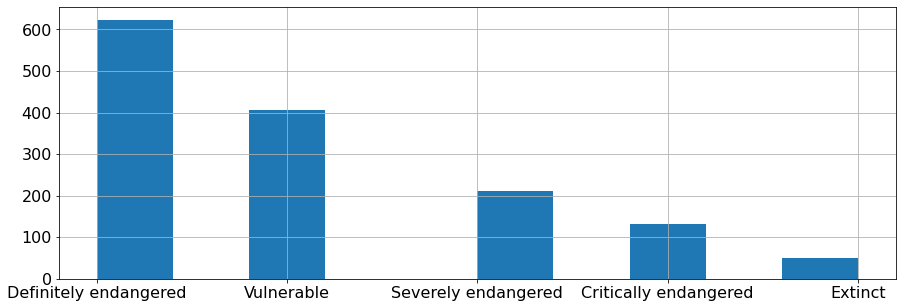

In [24]:
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
data_europe_nona["Endangerment Degree"].hist(figsize=(15,5)).get_figure().savefig('endangered_hist.png', format="png")

## Deep Neural Network for Time Series Classification

Building a deep neural network in order to classify the endangerment status of an language based on their past internet usage

In [25]:
data_europe_nona[["Year", "Internet_users","Language", "Country", "Endangerment Code"]]

,Year,Internet_users,Language,Country,Endangerment Code
95,1990,0,Albanian,Albania,2
97,1995,347,Albanian,Albania,2
99,1996,996,Albanian,Albania,2
101,1997,1503,Albanian,Albania,2
103,1998,2018,Albanian,Albania,2
...,...,...,...,...,...
12527,2013,15821975,Western Frisian,Netherlands,2
12528,2014,15481910,Western Frisian,Netherlands,2
12529,2015,15536692,Western Frisian,Netherlands,2
12530,2016,15358408,Western Frisian,Netherlands,2


## Data Pre-Processing

### Map Country-Language

In [26]:
def map_country_language(row):
    return row["Country"]+"-"+row["Language"]
data_europe_nona["Country-Language"]=data_europe_nona.apply(lambda row: map_country_language(row), axis=1)
data_europe_nona

<ipython-input-26-32dbf1e42569>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_europe_nona["Country-Language"]=data_europe_nona.apply(lambda row: map_country_language(row), axis=1)


,LangID,Language,Year,Internet_users,Country,CountryID,Endangerment Degree,Endangerment Code,Country-Language
95,1052.0,Albanian,1990,0,Albania,ALB,Definitely endangered,2,Albania-Albanian
97,1052.0,Albanian,1995,347,Albania,ALB,Definitely endangered,2,Albania-Albanian
99,1052.0,Albanian,1996,996,Albania,ALB,Definitely endangered,2,Albania-Albanian
101,1052.0,Albanian,1997,1503,Albania,ALB,Definitely endangered,2,Albania-Albanian
103,1052.0,Albanian,1998,2018,Albania,ALB,Definitely endangered,2,Albania-Albanian
...,...,...,...,...,...,...,...,...,...
12527,1122.0,Western Frisian,2013,15821975,Netherlands,NLD,Definitely endangered,2,Netherlands-Western Frisian
12528,1122.0,Western Frisian,2014,15481910,Netherlands,NLD,Definitely endangered,2,Netherlands-Western Frisian
12529,1122.0,Western Frisian,2015,15536692,Netherlands,NLD,Definitely endangered,2,Netherlands-Western Frisian
12530,1122.0,Western Frisian,2016,15358408,Netherlands,NLD,Definitely endangered,2,Netherlands-Western Frisian


### Number of Entities per Country-Language before standartization

Text(0.5, 0, 'Number of entries')

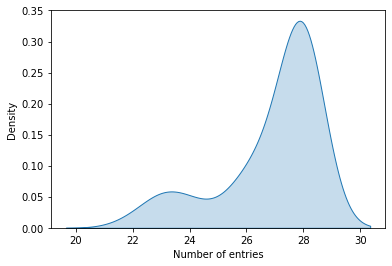

In [30]:
import seaborn as sns
import numpy as np
number_of_entries = []
country_langs= data_europe_nona["Country-Language"].drop_duplicates().to_list()
for c in country_langs:
    number_of_entries.append(len(data_europe_nona[data_europe_nona["Country-Language"]==c]))
sns.kdeplot(number_of_entries,fill=True)
plt.xlabel('Number of entries')

In [31]:
number_of_entries = np.array(number_of_entries)
min_number = number_of_entries.min()
red_data = data_europe_nona[data_europe_nona['Country-Language']==country_langs[0]]
red_data = red_data[len(red_data)-min_number::]
for i in range(1,len(country_langs)):
    data_i = data_europe_nona[data_europe_nona['Country-Language']==country_langs[i]]
    data_i = data_i[len(data_i)-min_number::]
    red_data = red_data.append(data_i)
red_data = red_data[["Year","Internet_users","Country-Language","Endangerment Degree"]]
red_data.head()

,Year,Internet_users,Country-Language,Endangerment Degree
97,1995,347,Albania-Albanian,Definitely endangered
99,1996,996,Albania-Albanian,Definitely endangered
101,1997,1503,Albania-Albanian,Definitely endangered
103,1998,2018,Albania-Albanian,Definitely endangered
105,1999,2537,Albania-Albanian,Definitely endangered


### Histogram of the number of entries after the standardization:

Text(0.5, 0, 'Number of entries')

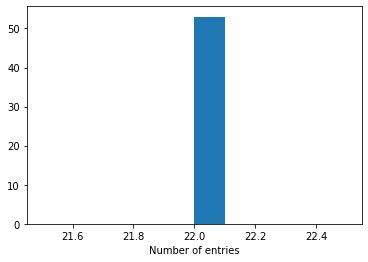

In [33]:
number_of_entries = []
for c in country_langs:
    number_of_entries.append(len(red_data[red_data['Country-Language']==c]))
plt.hist(number_of_entries)
plt.xlabel('Number of entries')

/Users/anton/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Endangerment Degree', ylabel='count'>

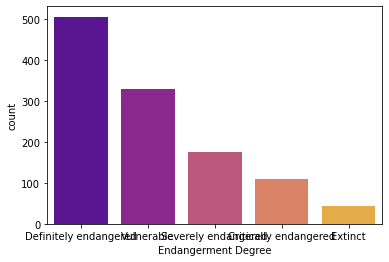

In [34]:
sns.countplot(red_data["Endangerment Degree"],palette='plasma')

### Taking a look at internet-usage progression combined with the endangerment status

In [35]:
red_data_label = red_data.reset_index().drop('index',axis=1)
tot = int(len(red_data_label)/min_number)
labels=[]
for i in range(0,tot):
    labels.append(red_data_label.loc[i*min_number:(i+1)*min_number]["Endangerment Degree"].to_list()[0])

In [36]:
def pick_country_language(data):
    country_langs = data["Country-Language"].drop_duplicates().to_list()
    country_lang = np.random.choice(country_langs)
    return data[data['Country-Language']==country_lang]

def plot_data(data,color='navy'):
    data = data.reset_index().drop(columns='index')
    country_lang = data_i[0:1]["Country-Language"].to_list()[0]
    index_to_plot = np.linspace(0,len(data)-1,5).astype(int)
    indexes = data.index.to_list()
    y = data["Internet_users"]
    x = data["Year"]
    sns.lineplot(x=indexes,y=y,label=country_lang,color=color)
    plt.xticks(index_to_plot,data["Year"].loc[index_to_plot])
    plt.legend(fontsize=20)
    plt.xlabel('Year',fontsize=30)
    plt.ylabel('Country Languages',fontsize=30)

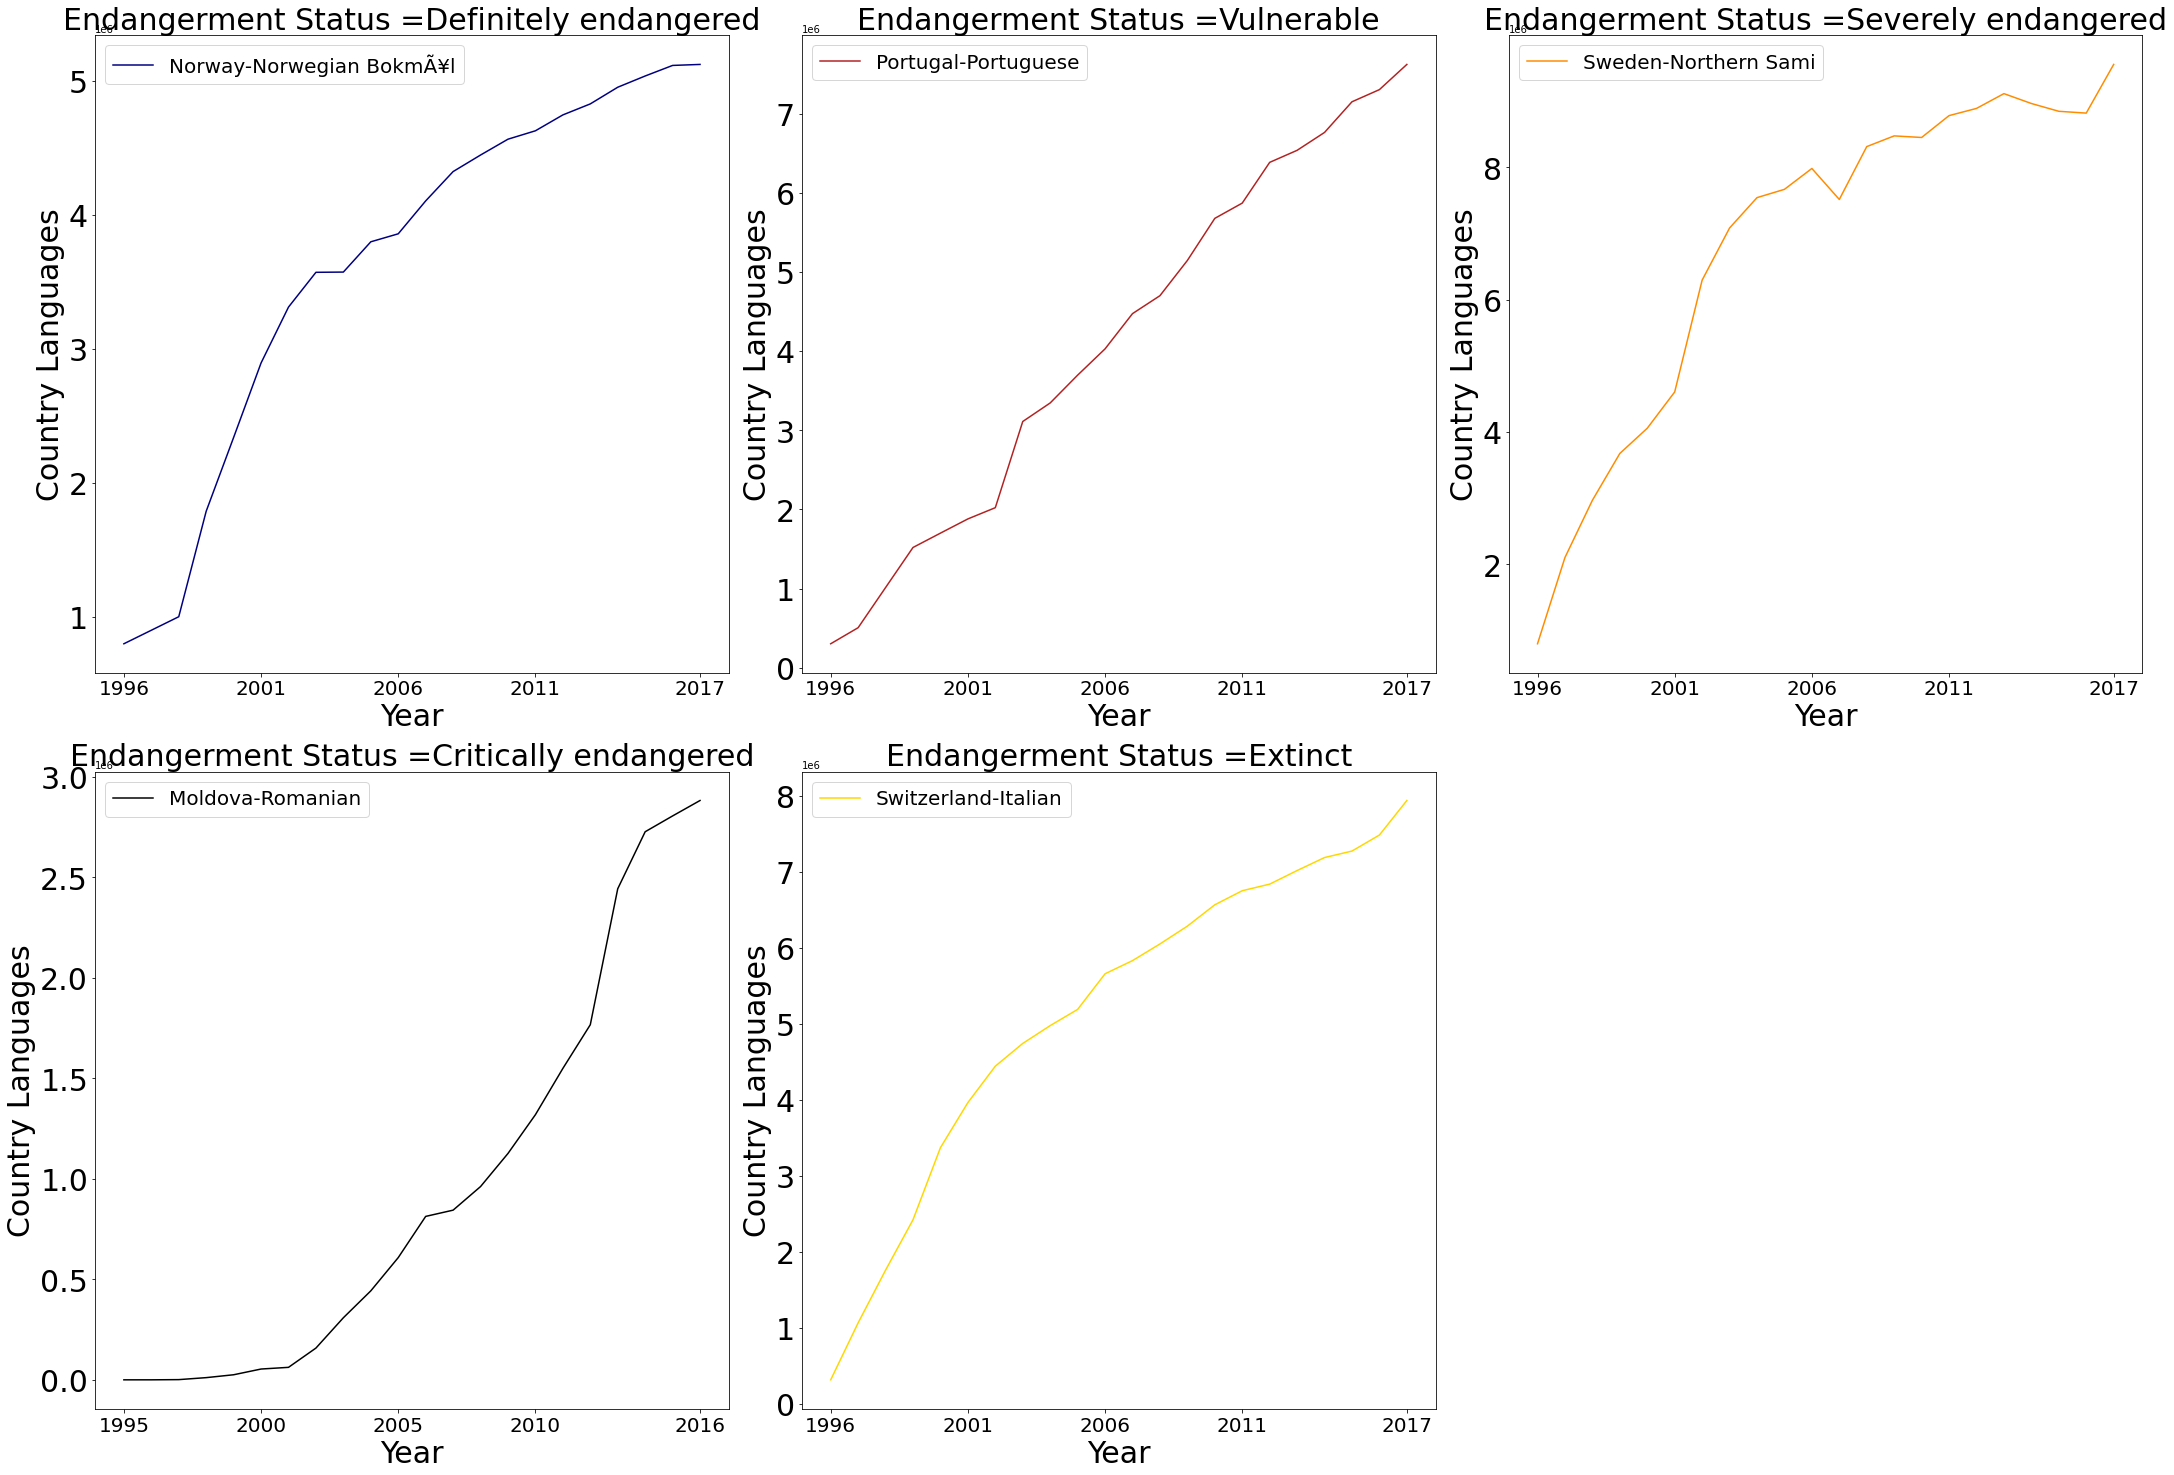

In [37]:
endangerment_codes = red_data["Endangerment Degree"].drop_duplicates().to_list()
data_list = []
for e_degree in endangerment_codes:
    data_list.append(red_data[red_data["Endangerment Degree"]==e_degree])
i=1
colors = ['navy','firebrick','darkorange','k','gold','darkgrey','purple']
plt.figure(figsize=(30,30))

for e_degree_data in data_list:
    plt.subplot(3,3,i)
    data_i = pick_country_language(e_degree_data)
    e_degree = data_i["Endangerment Degree"].to_list()[0]
    plt.title('Endangerment Status =%s'%(e_degree),fontsize=30)
    plot_data(data_i,color=colors[i-1])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=30)
    i=i+1
plt.tight_layout()

### Prepare data to use on DL model

In [43]:
from sklearn.preprocessing import LabelEncoder
labels = np.array(labels)
le = LabelEncoder()
le = le.fit(labels)
labels = np.array(le.transform(labels))
red_data = red_data.reset_index().drop(columns='index')
len_data = len(red_data)
len_train_country = int((len_data/min_number)*0.8)
len_train = int(len_train_country*min_number)
red_train_data = red_data[0:len_train]
red_test_data = red_data[len_train:len_data]
len_test_country = int((len(red_test_data)/min_number))

x = np.array(red_data["Internet_users"])
y = labels
x = x.reshape(min_number,int(len(x)/min_number))
idx = np.arange(0,22,1)
idx_random = np.random.choice(idx,len(y))
x_train,y_train = x[idx_random][0:len_train_country],y[idx_random][0:len_train_country]
x_test,y_test = x[idx_random][len_train_country:len(y)],y[idx_random][len_train_country:len(y)]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
num_classes = 5

In [39]:
len(x)

22

### Model

In [44]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])


### Summary

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 53, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 53, 64)            256       
_________________________________________________________________
batch_normalization (BatchNo (None, 53, 64)            256       
_________________________________________________________________
re_lu (ReLU)                 (None, 53, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 53, 64)            12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 64)            256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 53, 64)            0     

### Train the model

In [46]:
epochs = 500
batch_size = 5

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/500
42/42 [==============================] - 1s 17ms/sample - loss: 1.5693 - sparse_categorical_accuracy: 0.3333
Epoch 2/500
42/42 [==============================] - 0s 2ms/sample - loss: 1.2653 - sparse_categorical_accuracy: 0.5714
Epoch 3/500
42/42 [==============================] - 0s 2ms/sample - loss: 1.1183 - sparse_categorical_accuracy: 0.6190
Epoch 4/500
42/42 [==============================] - 0s 2ms/sample - loss: 1.0045 - sparse_categorical_accuracy: 0.6429
Epoch 5/500
42/42 [==============================] - 0s 2ms/sample - loss: 0.9181 - sparse_categorical_accuracy: 0.6667
Epoch 6/500
42/42 [==============================] - 0s 2ms/sample - loss: 0.8935 - sparse_categorical_accuracy: 0.6905
Epoch 7/500
42/42 [==============================] - 0s 795us/sample - loss: 0.9483 - sparse_categorical_accuracy: 0.6667
Epoch 8/500
42/42 [==============================] - 0s 2ms/sample - loss: 0.8512 - sparse_categorical_accuracy: 0.7143
Epoch 9/500
42/42 [==================

Epoch 68/500
42/42 [==============================] - 0s 673us/sample - loss: 0.6419 - sparse_categorical_accuracy: 0.7857
Epoch 69/500
42/42 [==============================] - 0s 655us/sample - loss: 0.6486 - sparse_categorical_accuracy: 0.7619
Epoch 70/500
42/42 [==============================] - 0s 612us/sample - loss: 0.6248 - sparse_categorical_accuracy: 0.7857
Epoch 71/500
42/42 [==============================] - 0s 568us/sample - loss: 0.6502 - sparse_categorical_accuracy: 0.7619
Epoch 72/500
42/42 [==============================] - 0s 606us/sample - loss: 0.6355 - sparse_categorical_accuracy: 0.7619
Epoch 73/500
42/42 [==============================] - 0s 591us/sample - loss: 0.5781 - sparse_categorical_accuracy: 0.7857
Epoch 74/500
42/42 [==============================] - 0s 1ms/sample - loss: 0.6356 - sparse_categorical_accuracy: 0.7381
Epoch 75/500
42/42 [==============================] - 0s 632us/sample - loss: 0.6143 - sparse_categorical_accuracy: 0.8095
Epoch 76/500
42/42

42/42 [==============================] - 0s 609us/sample - loss: 0.4384 - sparse_categorical_accuracy: 0.8571
Epoch 201/500
42/42 [==============================] - 0s 627us/sample - loss: 0.5075 - sparse_categorical_accuracy: 0.8095
Epoch 202/500
42/42 [==============================] - 0s 564us/sample - loss: 0.4599 - sparse_categorical_accuracy: 0.8571
Epoch 203/500
42/42 [==============================] - 0s 582us/sample - loss: 0.4450 - sparse_categorical_accuracy: 0.8333
Epoch 204/500
42/42 [==============================] - 0s 572us/sample - loss: 0.5046 - sparse_categorical_accuracy: 0.8571
Epoch 205/500
42/42 [==============================] - 0s 638us/sample - loss: 0.4728 - sparse_categorical_accuracy: 0.8333
Epoch 206/500
42/42 [==============================] - 0s 571us/sample - loss: 0.6051 - sparse_categorical_accuracy: 0.7381
Epoch 207/500
42/42 [==============================] - 0s 560us/sample - loss: 0.4480 - sparse_categorical_accuracy: 0.9048
Epoch 208/500
42/42 [=

In [47]:
### Results:

In [48]:
pred = model.predict(x_test)
res = []
for p in pred:
    res.append(p.argmax())
print('The accuracy score on the test set is %.2f'%accuracy_score(res,y_test))

The accuracy score on the test set is 0.82


In [49]:
print(classification_report(res,y_test))

              precision    recall  f1-score   support

           1       1.00      0.71      0.83         7
           3       1.00      1.00      1.00         1
           4       0.60      1.00      0.75         3

    accuracy                           0.82        11
   macro avg       0.87      0.90      0.86        11
weighted avg       0.89      0.82      0.83        11



### Confusion Matrix

In [51]:
res = le.inverse_transform(res)
y_test = le.inverse_transform(y_test)
results = pd.DataFrame({'Predict':res,'Target':y_test})
results.head()

,Predict,Target
0,1,4
1,4,4
2,1,1
3,3,3
4,1,1
